In [1]:
# required modules (skip if already installed)
if False:
    !pip install pyroaring
    !pip install pyfim 
    # if previous does not work, try: !conda install -c conda-forge pyfim
    !pip install lightgbm
    !pip install fairlearn
    !pip install pydotplus

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# global imports
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# local imports
sys.path.append('../src/') # local path
import dd

# general settings  
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=11)
plt.rc('legend', fontsize=11)
plt.rc('lines', linewidth=2)
plt.rc('axes', linewidth=2)
plt.rc('axes', edgecolor='k')
plt.rc('xtick.major', width=2)
plt.rc('xtick.major', size=6)
plt.rc('ytick.major', width=2)
plt.rc('ytick.major', size=6)
plt.rc('pdf', fonttype=42)
plt.rc('ps', fonttype=42)

### Data load and preparation

In [3]:
# read dataset
df = pd.read_csv('../data/adult_continuous.csv', na_values='?')
# remove unused columns
del df['fnlwgt']
del df['education-num']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       46043 non-null  object
 2   education       48842 non-null  object
 3   marital-status  48842 non-null  object
 4   occupation      46033 non-null  object
 5   relationship    48842 non-null  object
 6   race            48842 non-null  object
 7   sex             48842 non-null  object
 8   capital-gain    48842 non-null  int64 
 9   capital-loss    48842 non-null  int64 
 10  hours-per-week  48842 non-null  int64 
 11  native-country  47985 non-null  object
 12  class           48842 non-null  object
dtypes: int64(4), object(9)
memory usage: 4.8+ MB


In [4]:
# some missing values present
df.isna().sum()

age                  0
workclass         2799
education            0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
class                0
dtype: int64

In [5]:
df.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [6]:
# nominal-ordinal-continuous partition of predictive attributes (required for distance functions)
nominal_atts = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
ordinal_atts = ['education']
continuous_atts = ['age', 'capital-gain', 'capital-loss', 'hours-per-week']
# encoding of ordinal attributes as integers plus (optional) encoding of nominal/target attributes
decode = {
    'education': {
        1:'Preschool', 2:'1st-4th', 3:'5th-6th', 4:'7th-8th', 5:'9th', 6:'10th', 7:'11th',
        8:'12th', 9:'HS-grad', 10:'Some-college', 11:'Assoc-voc', 12:'Assoc-acdm', 13:'Bachelors', 
        14:'Masters', 15:'Prof-school', 16:'Doctorate' },
    'class': {0: '<=50K', 1: '>50K'}
}
# predictive attributes (for models)
target = 'class'
pred_atts = nominal_atts + ordinal_atts + continuous_atts
pred_all = pred_atts + [target]

In [7]:
# encode nominal, ordinal, and target attribute
df_code = dd.Encode(nominal_atts+ordinal_atts+[target], decode)
df = df_code.fit_transform(df)
# set ordinal type as int (instead of category)
df[ordinal_atts] = df[ordinal_atts].astype(int)
# set target attribute as int (instead of category)
df[target] = df[target].astype(int)
# workclass, occupation and native-country are float because there are missing values
df.head()

,workclass,marital-status,occupation,relationship,race,sex,native-country,education,class,capital-gain,capital-loss,age,hours-per-week
0,6.0,4,0.0,1,4,1,38.0,13,0,2174,0,39,40
1,5.0,2,3.0,0,4,1,38.0,13,0,0,0,50,13
2,3.0,0,5.0,1,4,1,38.0,9,0,0,0,38,40
3,3.0,2,5.0,0,2,1,38.0,7,0,0,0,53,40
4,3.0,2,9.0,5,2,0,4.0,13,0,0,0,28,40


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   workclass       46043 non-null  category
 1   marital-status  48842 non-null  category
 2   occupation      46033 non-null  category
 3   relationship    48842 non-null  category
 4   race            48842 non-null  category
 5   sex             48842 non-null  category
 6   native-country  47985 non-null  category
 7   education       48842 non-null  int32   
 8   class           48842 non-null  int32   
 9   capital-gain    48842 non-null  int64   
 10  capital-loss    48842 non-null  int64   
 11  age             48842 non-null  int64   
 12  hours-per-week  48842 non-null  int64   
dtypes: category(7), int32(2), int64(4)
memory usage: 2.2 MB


In [9]:
# dictionary of encodings for each discrete column
df_code.decode

{'education': {1: 'Preschool',
  2: '1st-4th',
  3: '5th-6th',
  4: '7th-8th',
  5: '9th',
  6: '10th',
  7: '11th',
  8: '12th',
  9: 'HS-grad',
  10: 'Some-college',
  11: 'Assoc-voc',
  12: 'Assoc-acdm',
  13: 'Bachelors',
  14: 'Masters',
  15: 'Prof-school',
  16: 'Doctorate'},
 'class': {0: '<=50K', 1: '>50K'},
 'workclass': {0: 'Federal-gov',
  1: 'Local-gov',
  2: 'Never-worked',
  3: 'Private',
  4: 'Self-emp-inc',
  5: 'Self-emp-not-inc',
  6: 'State-gov',
  7: 'Without-pay'},
 'marital-status': {0: 'Divorced',
  1: 'Married-AF-spouse',
  2: 'Married-civ-spouse',
  3: 'Married-spouse-absent',
  4: 'Never-married',
  5: 'Separated',
  6: 'Widowed'},
 'occupation': {0: 'Adm-clerical',
  1: 'Armed-Forces',
  2: 'Craft-repair',
  3: 'Exec-managerial',
  4: 'Farming-fishing',
  5: 'Handlers-cleaners',
  6: 'Machine-op-inspct',
  7: 'Other-service',
  8: 'Priv-house-serv',
  9: 'Prof-specialty',
  10: 'Protective-serv',
  11: 'Sales',
  12: 'Tech-support',
  13: 'Transport-moving'}

In [10]:
# split train test 
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.33, random_state=42)

### Individual discrimination settings

In [11]:
# object for indvidual discrimination analysis
dist = dd.ID(df_train, nominal_atts, continuous_atts, ordinal_atts)
# protected/unprotected groups attribute
sensitive_att = 'race'
# unprotected/reference group
unpro_val = df_code.encode['race']['White']
# number of neighbors
k = 16

In [12]:
# example of distance between two instances
print(df.loc[0], '\n', df.loc[1])
dist.kdd2011dist(df.loc[0], df.loc[1])

workclass            6.0
marital-status       4.0
occupation           0.0
relationship         1.0
race                 4.0
sex                  1.0
native-country      38.0
education           13.0
class                0.0
capital-gain      2174.0
capital-loss         0.0
age                 39.0
hours-per-week      40.0
Name: 0, dtype: float64 
 workclass          5.0
marital-status     2.0
occupation         3.0
relationship       0.0
race               4.0
sex                1.0
native-country    38.0
education         13.0
class              0.0
capital-gain       0.0
capital-loss       0.0
age               50.0
hours-per-week    13.0
Name: 1, dtype: float64


0.6065556247498695

In [13]:
# example of distance between an instance and each instance in a dataframe
print(df.loc[0], '\n', df.loc[1:5])
dist.kdd2011dist(df.loc[0], df.loc[1:5])

workclass            6.0
marital-status       4.0
occupation           0.0
relationship         1.0
race                 4.0
sex                  1.0
native-country      38.0
education           13.0
class                0.0
capital-gain      2174.0
capital-loss         0.0
age                 39.0
hours-per-week      40.0
Name: 0, dtype: float64 
   workclass marital-status occupation relationship race sex native-country  \
1       5.0              2        3.0            0    4   1           38.0   
2       3.0              0        5.0            1    4   1           38.0   
3       3.0              2        5.0            0    2   1           38.0   
4       3.0              2        9.0            5    2   0            4.0   
5       3.0              2        3.0            5    4   0           38.0   

   education  class  capital-gain  capital-loss  age  hours-per-week  
1         13      0             0             0   50              13  
2          9      0             0     

1    0.606556
2    0.302983
3    0.559571
4    0.674717
5    0.459045
dtype: float64

### Individual discrimination on training data

In [14]:
%%time
unpro_train = df_train[sensitive_att]==unpro_val
pro_train = df_train[sensitive_att]!=unpro_val
# sets risk difference for target based on top-k neighbor instances
df_train['t'] = dist.topkdiff(df_train, # dataframe
                              unpro_train, # unprotected
                              pro_train, # protected (could be a list)
                              target+'=0', # bad decision
                              dist.kdd2011dist, # distance
                              k) # k

CPU times: total: 2min 35s
Wall time: 2min 39s


In [15]:
df_train

,workclass,marital-status,occupation,relationship,race,sex,native-country,education,class,capital-gain,capital-loss,age,hours-per-week,t
5551,1.0,5,10.0,1,2,1,38.0,9,0,0,0,51,40,0.25
36721,4.0,2,9.0,0,4,1,38.0,16,1,15024,0,62,45,0.00
2638,NaN,2,NaN,0,4,1,38.0,11,1,0,0,52,50,0.00
36214,3.0,0,3.0,4,4,1,38.0,13,1,15020,0,50,40,0.00
27010,4.0,2,11.0,0,4,1,38.0,13,1,0,0,42,60,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,3.0,2,3.0,0,1,1,NaN,13,1,0,1887,35,50,0.00
44732,3.0,4,6.0,3,4,0,38.0,9,0,0,0,21,40,0.00
38158,3.0,0,0.0,1,4,0,38.0,9,0,0,0,23,40,0.00
860,3.0,4,0.0,3,4,0,38.0,7,0,0,0,18,20,0.00


### Individual discrimination on test data

In [16]:
# training model and make predictions - lightgbm able to deal with categorial attributes (no need for onehot encodings)
import lightgbm as lgb

clf = lgb.LGBMClassifier(random_state=42)
clf.fit(df_train[pred_atts], df_train[target])
# add predicted class and score in the df_test
df_test['pred_b'] = clf.predict(df_test[pred_atts])
df_test['score_b'] = clf.predict_proba(df_test[pred_atts])[:,1]
df_test.head()

,workclass,marital-status,occupation,relationship,race,sex,native-country,education,class,capital-gain,capital-loss,age,hours-per-week,pred_b,score_b
7762,3.0,4,7.0,1,4,1,38.0,9,0,0,0,18,20,0,0.000425
23881,3.0,4,11.0,3,4,0,38.0,8,0,0,0,17,20,0,0.000432
30507,1.0,4,5.0,2,2,1,38.0,9,0,0,0,25,40,0,0.003119
28911,3.0,4,11.0,3,4,0,38.0,10,0,0,0,20,30,0,0.000589
19484,3.0,4,6.0,4,0,1,32.0,9,0,0,0,47,56,0,0.011643


In [17]:
%%time
unpro_test = df_test[sensitive_att]==unpro_val
pro_test = df_test[sensitive_att]!=unpro_val
# sets risk difference for target based on top-k neighbor instances
df_test['t_b'] = dist.topkdiff(df_test, # dataset
                              unpro_test, # unprotected
                              pro_test, # protected (could be a list)
                              'pred_b=0', # bad decision
                              dist.kdd2011dist, # distance
                              k) # k

CPU times: total: 1min 5s
Wall time: 1min 9s


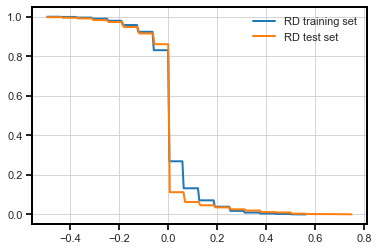

In [18]:
# CCDF of risk difference in both training and test
pro_train_neg_dec = pro_train & (df_train[target]==0)
count, bins_count = np.histogram(df_train[pro_train_neg_dec]['t'], bins=200)
ccdf = 1 - np.cumsum(count)/sum(count)
plt.plot(bins_count[1:], ccdf, label='RD training set')
pro_test_neg_dec = pro_test & (df_test['pred_b']==0)
count, bins_count = np.histogram(df_test[pro_test_neg_dec]['t_b'], bins=200)
ccdf = 1 - np.cumsum(count)/sum(count)
plt.plot(bins_count[1:], ccdf, label='RD test set')
plt.legend()
plt.show()

### Correct training data and re-train

In [19]:
# set maximum RD
t = 0.15
# correct class value
df_train[target+'_corrected'] = np.where( pro_train_neg_dec & (df_train['t']>=t), 1, df_train[target])

In [20]:
# refit
clf.fit(df_train[pred_atts], df_train[target+'_corrected'])
# add predicted class and score in the df_test
df_test['pred_a'] = clf.predict(df_test[pred_atts])
df_test['score_a'] = clf.predict_proba(df_test[pred_atts])[:,1]

In [21]:
%%time
# sets risk difference for target based on top-k neighbor instances
df_test['t_a'] = dist.topkdiff(df_test, # dataset
                              unpro_test, # unprotected
                              pro_test, # protected (could be a list)
                              'pred_a=0', # decision
                              dist.kdd2011dist, # distance
                              k) # k

CPU times: total: 1min 9s
Wall time: 1min 12s


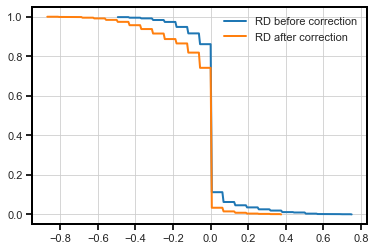

In [22]:
# CCDF of risk difference for bad decision instances in test set
count, bins_count = np.histogram(df_test[pro_test_neg_dec]['t_b'], bins=200)
ccdf = 1 - np.cumsum(count)/sum(count)
plt.plot(bins_count[1:], ccdf, label='RD before correction')
pro_test_neg_dec_a = pro_test & (df_test['pred_a']==0)
count, bins_count = np.histogram(df_test[pro_test_neg_dec_a]['t_a'], bins=200)
ccdf = 1 - np.cumsum(count)/sum(count)
plt.plot(bins_count[1:], ccdf, label='RD after correction')
plt.legend()
plt.show()

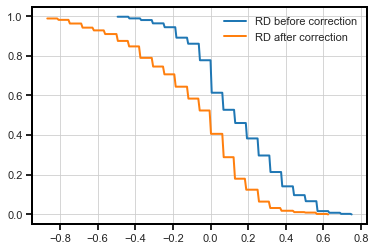

In [23]:
# CCDF of risk difference for good decision instances in test set
pro_train_pos_dec = pro_test & (df_test[target]==1)
count, bins_count = np.histogram(df_test[pro_train_pos_dec]['t_b'], bins=200)
ccdf = 1 - np.cumsum(count)/sum(count)
plt.plot(bins_count[1:], ccdf, label='RD before correction')
pro_train_pos_dec_a = pro_test & (df_test['pred_a']==1)
count, bins_count = np.histogram(df_test[pro_train_pos_dec_a]['t_a'], bins=200)
ccdf = 1 - np.cumsum(count)/sum(count)
plt.plot(bins_count[1:], ccdf, label='RD after correction')
plt.legend()
plt.show()

### Explain individual discrimination in training data

In [24]:
# set disc attribute
df_train['disc'] = df_train['t'] >= t
df_pro_train = df_train[pro_train]

In [25]:
# using DecisionTree requires encoding of nominal attributes
# (optional, nan should be imputed, as it is now they are treated as special categorical values)
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

preprocess = ColumnTransformer([("enc", OneHotEncoder(), nominal_atts)], remainder = 'passthrough')
preprocess.fit(df_pro_train[pred_atts])

# decode back onehotencoded column names
def mapf(f):
    if f[:3]=='rem':
        return f[11:]
    f = f[5:]
    pos = f.find('_')
    att = f[:pos]
    value = float(f[pos+1:])
    return att+'='+('nan' if np.isnan(value) else df_code.decode[att][int(value)])

#print(preprocess.get_feature_names_out())
fnames = [mapf(f) for f in preprocess.get_feature_names_out()]
#print(fnames)

In [26]:
# surrogate model
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

sm = make_pipeline(preprocess, DecisionTreeClassifier(max_depth=3))
sm.fit(df_pro_train[pred_atts], df_train[pro_train]['disc'])

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('enc', OneHotEncoder(),
                                                  ['workclass',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=3))])

In [27]:
# add if needed
if True:
    import os
    os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

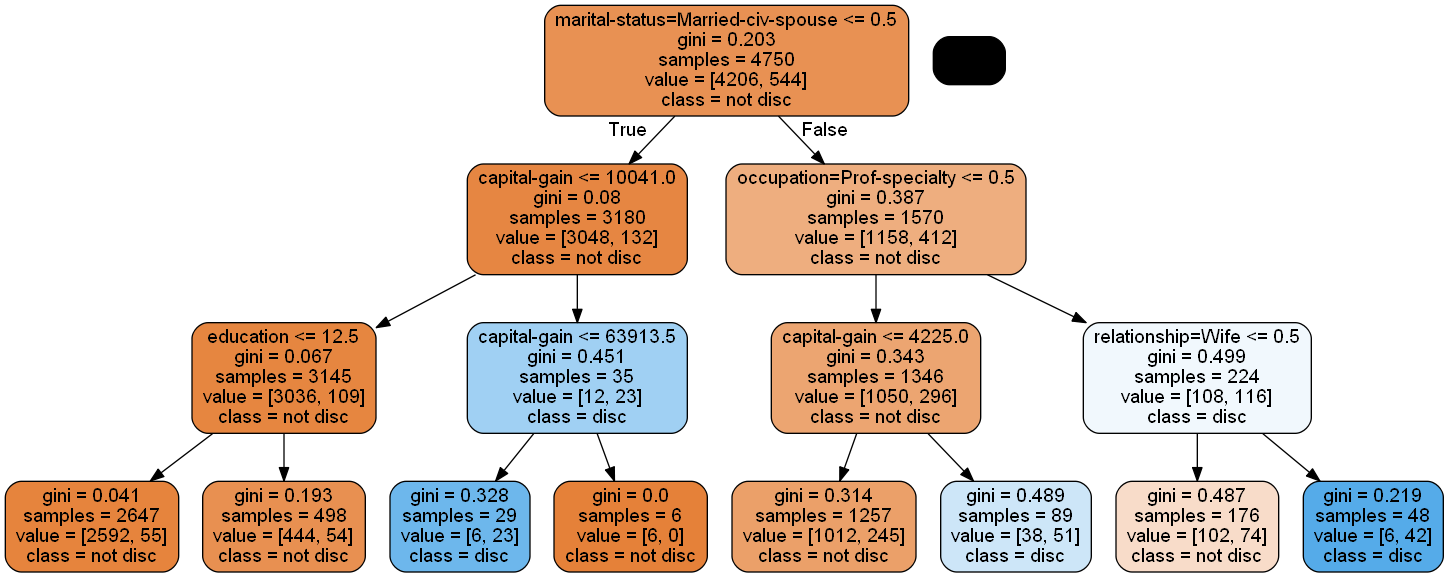

In [28]:
# visualize surrogate model
from sklearn import tree
from IPython.display import Image
import pydotplus

dot_data = tree.export_graphviz(sm[1], out_file=None, feature_names=fnames, 
             class_names=['not disc', 'disc'], filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())